# 优达学城的数据科学家毕业项目-星巴克促销效果预测

### 项目基本情况

这是我在优达学城学习数据科学家课程的毕业项目。数据科学家课程总体感觉不错，涉及了数据科学的各个方面，对新手老手，会有不同的收益，课程地址是：https://www.udacity.com/course/data-scientist-nanodegree--nd025。个人比较推荐：-）这个项目提供了星巴克的促销活动相关的真实数据，主要是三个数据文件，在data目录可以看到：
  
- 第一个文件（portfolio.json）是关于促销活动的，主要描述了一个促销活动的门槛，奖励标准等
- 第二个文件（profile.json） 是客户的基本属性信息，描述了他们的性别，收入，会员创建日期等
- 第三个文件（transcript.json）是客户和星巴克的促销活动推送的互动记录

### 问题描述

这里我选择切入的一个角度是，建立一个模型，可以用来评估一个客户是否会对促销感兴趣。整个数据处理，探索和建模过程，我放在了一个notebook文件里，文件名为Starbucks_Capstone_notebook-zh.ipynb。我基本上是分了三个大的部分：

* 第一步：数据整理，主要是对三个文件的数据做些标准化，对某些类别字段做独热编码，最后并合并成一个大的文件，方便进行数据探索和建模
* 第二步：数据探索，这一步主要是探索数据的特性，做些可视化的展现，帮助理解数据
* 第三步：数据建模和评估，我主要是查看了sklearn的网站，把几个适合用来做分类的模型都拿来评估一下，其中也用到了网格搜索等在之前项目中用到的技巧

经过三步之后，我给出结论

### 衡量指标

对于模型的衡量指标，分类模型有准确率，精确率，召回率和F1分数，比较有用的是F1分数，我会用F1分数来选择最优的模型，并根据最佳的模型给出结论。同时，根据模型，还可以对各个因子的重要性有认识和把握


### 数据集

一共有三个数据文件：

* portfolio.json – 包括推送的 id 和每个推送的元数据（持续时间、种类等等）
* profile.json – 每个顾客的人口统计数据
* transcript.json – 交易、收到的推送、查看的推送和完成的推送的记录

以下是文件中每个变量的类型和解释 ：

**portfolio.json**
* id (string) – 推送的id
* offer_type (string) – 推送的种类，例如 BOGO、打折（discount）、信息（informational）
* difficulty (int) – 满足推送的要求所需的最少花费
* reward (int) – 满足推送的要求后给与的优惠
* duration (int) – 推送持续的时间，单位是天
* channels (字符串列表)

**profile.json**
* age (int) – 顾客的年龄 
* became_member_on (int) – 该顾客第一次注册app的时间
* gender (str) – 顾客的性别（注意除了表示男性的 M 和表示女性的 F 之外，还有表示其他的 O）
* id (str) – 顾客id
* income (float) – 顾客的收入

**transcript.json**
* event (str) – 记录的描述（比如交易记录、推送已收到、推送已阅）
* person (str) – 顾客id
* time (int) – 单位是小时，测试开始时计时。该数据从时间点 t=0 开始
* value - (dict of strings) – 推送的id 或者交易的数额


In [1]:
# 基本的库导入
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 以下是Scikit-Learn的库导入
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
# 文件读取
portfolio = pd.read_json("data/portfolio.json", orient="records", lines=True)
profile = pd.read_json("data/profile.json", orient="records", lines=True)
transcript = pd.read_json("data/transcript.json", orient="records", lines=True)

### 第一步，数据整理

#### 1.1 先看看三个文件的数据结构及其字段内容

In [3]:
# 三个数据集的大小先有个认识
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
# channels，是个类别数据，需要one-hot处理
print(portfolio["channels"].value_counts())
print("\n-------我是一条完美的分割线-------\n")
# offer_type是个类别数据，需要one-hot处理
print(portfolio["offer_type"].value_counts())


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

-------我是一条完美的分割线-------

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


(2180, 5) (17000, 5)


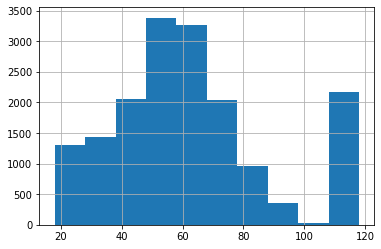

In [7]:
# 100岁以上的消费者竟然 有2180个，有点怪怪的
print(profile[profile["age"] > 100].shape, profile.shape)
profile["age"].hist()

In [8]:
# 不过也不要紧，由于性别和收入字段为空，只有5位100岁以上的消费者会保留
profile[profile["age"] > 100].sort_values(["gender", "income"]).head(10)

,age,became_member_on,gender,id,income
1556,101,20171004,F,4d2ccfcbbebf4bd9baf4b7e433d0e288,43000.0
14846,101,20171109,F,e0ea90ddd2f147e082d21e97f51ec1b1,56000.0
15800,101,20170309,F,047ad0135cfe4c0ea5ba019da4de9c52,59000.0
16864,101,20171127,F,1593d617fac246ef8e50dbb0ffd77f5f,82000.0
4100,101,20150526,F,d2fdc2be8ab64e4ba04830d441e53fd5,99000.0
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


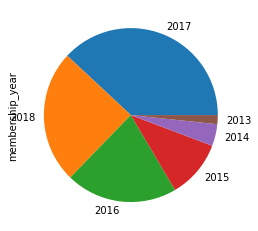

In [9]:
# became_member_on是个字符串，把年份取出来看看
# 新会员数量比老会员多很多
profile["membership_year"] = pd.to_datetime(profile["became_member_on"], format="%Y%m%d").dt.year
profile["membership_year"].value_counts().plot.pie()

M    8484
F    6129
O     212
Name: gender, dtype: int64


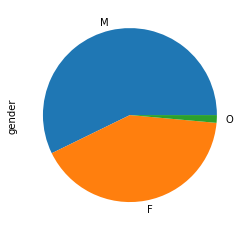

In [10]:
# 性别有212条"O"的记录，不算特别多，删除，这一列就两个值，做个one-hot
print(profile["gender"].value_counts())
profile["gender"].value_counts().plot.pie()

(17000, 6) (2175, 6)


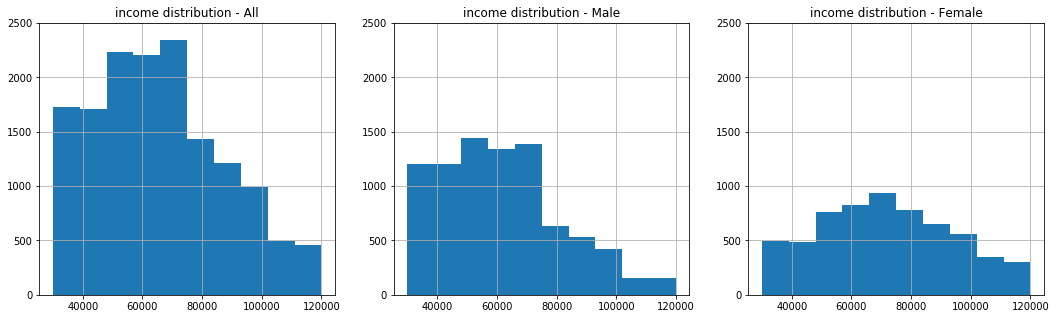

In [11]:
# 收入为空的记录有点多......不过经过之前的分析，发现都是些100岁以上没有收入的“老人”
# 其实我觉得是消费者故意留下的脏数据或者是星巴克收集数据的过程中有些小问题
print(profile.shape, profile[profile["income"].isna()].shape)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 收入和性别有关系吗？-- 男性高收入的还少点......
axes[0].set_title("income distribution - All")
axes[0].set_ylim(top=2500)
axes[1].set_title("income distribution - Male")
axes[1].set_ylim(top=2500)
axes[2].set_title("income distribution - Female")
axes[2].set_ylim(top=2500)

profile["income"].hist(ax=axes[0])
profile[profile["gender"]=="M"]["income"].hist(ax=axes[1])
profile[profile["gender"]=="F"]["income"].hist(ax=axes[2])

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


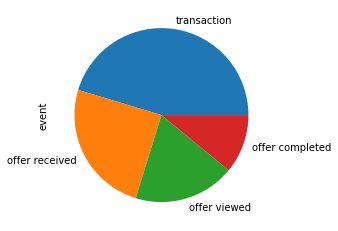

In [14]:
# Event列只有四个类别，实际上这个trascript数据集，混合了推送的互动信息和消费者的消费记录，应该分开成为四个数据集
transcript["event"].value_counts().plot.pie()

In [15]:
# 对于transaction类型记录，value里头是消费金额
transcript[transcript["event"] == "transaction"].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [16]:
transcript[transcript["event"] == "offer received"].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript[transcript["event"] == "offer viewed"].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [18]:
transcript[transcript["event"] == "offer completed"].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


总结一下理解到的关键信息

* portfolio表的channel字段，需要根据里头的取值，处理成独立的字段，不然无法分析
* portfolio表的id列，重新命名成offer_id，方便table join
* portfolio表的offer_type，需要做独热编码
* -
* profile表的age字段，后续不好处理，根据直方图的观察，分成几个类做独热编码：青少年（20岁以下），青年（20岁到40岁），中年（40岁到60岁），中老年（60岁到80岁）和老年（80岁以上）
* profile表的became_member_on是个字符串，进行统计还不好搞，做个日期字段，然后年做one-hot（月份有点多，暂时先不做one-hot）
* profile表的性别列，有None值，应该是不合理数据，删除掉相关记录，同时做one-hot
* profile表的id列，重新命名成consumer_id，方便table join
* profile表中income列有空值，删除相关记录
* -
* transcript需要拆分成四个数据集，三个是offer互动，一个是consumer_transaction，用event的值区分
* transcript的value列，包含offer_id或者消费金额，这个字段需要处理成一个新的列
* transcript的person列，包含的是profile id，用来连接profile的外键，改个列名（consumer_id）方便后续处理

#### 1.2 完成数据清理和数据合并
* 1.2.1 清理profolio数据集

In [19]:
# 再瞄一眼portfolio数据集
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [20]:
# 处理channel字段
mlb = MultiLabelBinarizer()
mlb.fit(portfolio['channels'])
df_channels = pd.DataFrame(data=mlb.transform(portfolio['channels']), columns=mlb.classes_)
df_channels

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [21]:
# one-hot for offer type
df_offer_type = pd.get_dummies(portfolio["offer_type"])
df_offer_type

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [22]:
# 完成portfolio数据集清理
portfolio = pd.concat([portfolio, df_channels, df_offer_type], axis=1)

# 到后面发现留着原始数据，方便分析
# portfolio.drop(["channels", "offer_type"], inplace=True, axis=1)
new_columns = ["offer_id" if col== "id" else col for col in portfolio.columns]
portfolio.columns = new_columns
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


* 1.2.2 清理profile数据集

In [23]:
# 再瞄一眼profile数据集
profile.head()

,age,became_member_on,gender,id,income,membership_year
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017


In [24]:
# 删除空值的行和性别等于“O”的
profile = profile[profile["gender"].notna()]
profile = profile[profile["income"].notna()]
profile = profile[profile["gender"]!="O"]

In [25]:
# 处理一下年龄，做个范围的one-hot
profile["age_range"] = pd.cut(profile["age"], [20, 40, 60, 80, profile["age"].max()])
df_age = pd.get_dummies(profile["age_range"])
df_age.head()

    (20, 40]  (40, 60]  (60, 80]  (80, 101]
1          0         1         0          0
3          0         0         1          0
5          0         0         1          0
8          0         0         1          0
12         0         1         0          0

In [26]:
# 做一个注册年份的one-hot
df_year = pd.get_dummies(profile["membership_year"])
df_year.head()

,2013,2014,2015,2016,2017,2018
1,0,0,0,0,1,0
3,0,0,0,0,1,0
5,0,0,0,0,0,1
8,0,0,0,0,0,1
12,0,0,0,0,1,0


In [27]:
# 性别列做成one-hot
profile["gender"].replace("M", "Male", inplace=True)
profile["gender"].replace("F", "Female", inplace=True)
df_gender = pd.get_dummies(profile["gender"])
df_gender.head()

,Female,Male
1,1,0
3,1,0
5,0,1
8,0,1
12,0,1


In [28]:
# 完成profile数据集清理
profile = pd.concat([profile, df_year, df_age, df_gender], axis=1)

# profile.drop(["became_member_on", "gender", "age"], axis=1, inplace=True)
new_columns = ["consumer_id" if col== "id" else col for col in profile.columns]
profile.columns = new_columns
print(profile.shape)
profile.head()

(14613, 19)


,age,became_member_on,gender,consumer_id,income,membership_year,age_range,2013,2014,2015,2016,2017,2018,"(20, 40]","(40, 60]","(60, 80]","(80, 101]",Female,Male
1,55,20170715,Female,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,"(40, 60]",0,0,0,0,1,0,0,1,0,0,1,0
3,75,20170509,Female,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,"(60, 80]",0,0,0,0,1,0,0,0,1,0,1,0
5,68,20180426,Male,e2127556f4f64592b11af22de27a7932,70000.0,2018,"(60, 80]",0,0,0,0,0,1,0,0,1,0,0,1
8,65,20180209,Male,389bc3fa690240e798340f5a15918d5c,53000.0,2018,"(60, 80]",0,0,0,0,0,1,0,0,1,0,0,1
12,58,20171111,Male,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,"(40, 60]",0,0,0,0,1,0,0,1,0,0,0,1


* 1.2.3 清理transcript数据集

In [29]:
# 再瞄一眼transcript数据集
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [30]:
# 列名person先改为consumer_id
new_columns = ["consumer_id" if col== "person" else col for col in transcript.columns]
transcript.columns = new_columns

# 因为清理了一些profile记录，先把transcript里头的也相应清理一下
transcript = transcript[transcript["consumer_id"].isin(profile["consumer_id"])]

In [31]:
# transcript先分成两个数据集
transaction = transcript[transcript["event"]=="transaction"].copy()
offer = transcript[transcript["event"]!="transaction"].copy()

# 对于transation数据集，需要生成金额，用apply函数实现
transaction["amount"] = transaction['value'].apply(lambda x: x["amount"])

# 对于offer数据集，需要取出"offer id"，"offer id"中间有空格，总提示key error，只能调用values函数绕过去
offer["offer_id"] = offer["value"].apply(lambda x: list(x.values())[0])

# 对于offer数据集，event有三个类别，做成独立的表
offer_received = offer[offer["event"] == "offer received"].copy()
offer_viewed = offer[offer["event"] == "offer viewed"].copy()
offer_completed = offer[offer["event"] == "offer completed"].copy()

# 删除不必要字段
transaction.drop(["event", "value"], axis=1, inplace=True)
offer_received.drop(["event", "value"], axis=1, inplace=True)
offer_viewed.drop(["event", "value"], axis=1, inplace=True)
offer_completed.drop(["event", "value"], axis=1, inplace=True)

In [32]:
# 交易信息，由消费者，时间和消费金额信息
# 我的项目不涉及消费金额预测，有时间我在做些各维度的消费者画像
# 这部分数据暂时不用
print(transaction.shape)
transaction.head()

(122176, 3)


,consumer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [33]:
# 这是推送记录
print(offer_received.shape)
offer_received.head()

(65585, 3)


,consumer_id,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [34]:
# 这是推送的浏览记录
print(offer_viewed.shape)
offer_viewed.head()

(49087, 3)


,consumer_id,time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5


In [35]:
# 这是推送的完成记录
print(offer_completed.shape)
offer_completed.head()

(31943, 3)


,consumer_id,time,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


#### 1.2.4 基于offer_received表，生成数据宽表，并且生成必要的判断字段

* 一个推送对于不同的消费者，有不同的起止time值
* 一个活动还可以触达用户多次
* 起始的time，是offer received里头的time
* 终止的time，是起始的time加上offer主数据里头的duration （天数 X 24小时）

这里需要找出成功的推送，所谓成功的推送，是那些：
* 推送后，在有效日期内有浏览记录和完成记录
* 完成的时间是不早于浏览时间

In [36]:
# 对于每次推送，连接到portfolio数据集，计算一个截至时间（单位：小时）
offer_received = pd.merge(offer_received, portfolio[["offer_id", "duration"]], on="offer_id")
offer_received["end_time"] = offer_received["time"] + offer_received["duration"] * 24

In [37]:
# 接下来，由于需要用到“不等于”类型表连接，我借助一下SQL来完成，免得写复杂的循环函数，逐条循环处理offer_received数据集
engine = create_engine("sqlite:///offer.db" )

offer_received.to_sql("offer_received", engine, index=False, if_exists="replace") 
offer_viewed.to_sql("offer_viewed", engine, index=False, if_exists="replace") 
offer_completed.to_sql("offer_completed", engine, index=False, if_exists="replace") 

In [38]:
# 更高效的语句，用Python试了写个supporting functon，感觉挺难维护的，放弃了
# 主表是offer_received，这里的逻辑是关键，后续数据分析，主要基于这里的匹配逻辑
SQL = " \
SELECT r.consumer_id, r.offer_id, r.time, r.end_time, min(v.time) as viewed_time, max(c.time) as completed_time \
FROM offer_received r \
LEFT JOIN offer_viewed v \
ON (v.consumer_id = r.consumer_id \
    AND v.offer_id = r.offer_id \
    AND v.time >= r.time \
    AND v.time <= r.end_time) \
LEFT JOIN offer_completed c \
ON (c.consumer_id = r.consumer_id \
    AND c.offer_id = r.offer_id \
    AND c.time >= r.time \
    AND c.time <= r.end_time) \
GROUP BY r.consumer_id, r.offer_id, r.time, r.end_time \
"
offer_full = pd.read_sql(SQL, engine)

In [39]:
# 对于每一条推送，查找出有效期内的浏览和完成的记录及其时间
# 如果两个都存在，且完成是在浏览之后，就是一条valid的推送
# 65585个推送中，总共过滤出22492个有效的推送
offer_full["valid_ind"] = 0
offer_full.loc[offer_full[offer_full["completed_time"] >= offer_full["viewed_time"]].index, "valid_ind"] = 1
print(offer_full.shape, offer_full[offer_full["valid_ind"]==1].shape)
offer_full.head()

(65585, 7) (22492, 7)


,consumer_id,offer_id,time,end_time,viewed_time,completed_time,valid_ind
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576,744,NaN,576.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,432,372.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,240,192.0,NaN,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408,528,456.0,414.0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504,744,540.0,528.0,0


In [40]:
# 完成最后的表连接
df_clean = pd.merge(offer_full, profile, on="consumer_id")
df_clean = pd.merge(df_clean, portfolio, on="offer_id")
print(df_clean.shape)
df_clean.sample(10)

(65585, 37)


,consumer_id,offer_id,time,end_time,viewed_time,completed_time,valid_ind,age,became_member_on,gender,...,duration,offer_type,reward,email,mobile,social,web,bogo,discount,informational
6232,f3ab5d3926434b5c931f78eb07aa7787,2906b810c7d4411798c6938adc9daaa5,504,672,540.0,540.0,1,70,20160528,Male,...,7,discount,2,1,1,0,1,0,1,0
40847,3de34e36962a47f988fa0136f8ae22a9,ae264e3637204a6fb9bb56bc8210ddfd,408,576,414.0,474.0,1,65,20170405,Male,...,7,bogo,10,1,1,1,0,1,0,0
55497,7b08d79bc4104676b792f80ea4aeb332,9b98b8c7a33c4b65b9aebfe6a799e6d9,336,504,NaN,NaN,0,88,20171020,Female,...,7,bogo,5,1,1,0,1,1,0,0
36473,929464b411144357844a637642af2e2b,4d5c57ea9a6940dd891ad53e9dbe8da0,168,288,168.0,216.0,1,29,20171212,Female,...,5,bogo,10,1,1,1,1,1,0,0
43564,a608c569b0b142b48a926b53ef93e76e,ae264e3637204a6fb9bb56bc8210ddfd,504,672,528.0,582.0,1,50,20150226,Male,...,7,bogo,10,1,1,1,0,1,0,0
45219,e7d8d76f719648f28169097d374d2389,ae264e3637204a6fb9bb56bc8210ddfd,504,672,510.0,510.0,1,40,20161013,Male,...,7,bogo,10,1,1,1,0,1,0,0
40301,2b50d8e66de14044ad46ca57417faadf,ae264e3637204a6fb9bb56bc8210ddfd,0,168,18.0,NaN,0,29,20180519,Female,...,7,bogo,10,1,1,1,0,1,0,0
23492,974679ad6fc2430ca1239ec26f5aa33e,f19421c1d4aa40978ebb69ca19b0e20d,408,528,NaN,NaN,0,58,20151104,Male,...,5,bogo,5,1,1,1,1,1,0,0
26839,1c82551d7efb49e78be619e175979085,fafdcd668e3743c1bb461111dcafc2a4,336,576,384.0,342.0,0,56,20160703,Female,...,10,discount,2,1,1,1,1,0,1,0
21179,3dbbfc8fc19d40df9877aa53a91e601b,f19421c1d4aa40978ebb69ca19b0e20d,576,696,600.0,576.0,0,63,20170413,Female,...,5,bogo,5,1,1,1,1,1,0,0


In [ ]:
# 测试代码，用来抽查SQL返回的数据匹配情况
# offer_received[offer_received["consumer_id"]=="d7d5dc9730ff479c840e10eaa190e8bc"].sort_values("time")
# offer_viewed[offer_viewed["consumer_id"]=="d7d5dc9730ff479c840e10eaa190e8bc"].sort_values("time")
# offer_completed[offer_completed["consumer_id"]=="d7d5dc9730ff479c840e10eaa190e8bc"].sort_values("time")

### 第二步，数据探索

现在我们有了大量的数据，可以从不同的维度取观察一个offer成功的影响因素，看哪些因素，对影响推送的成功率，尤其重点应该关注消费者的属性，比如收入，年龄，性别和入会时间长短。这些都是常用到的分析维度

,offer_id,count,sum,success_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6627,1321,0.199336
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6563,4112,0.626543
2,2906b810c7d4411798c6938adc9daaa5,6543,2049,0.313159
3,3f207df678b143eea3cee63160fa8bed,6561,0,0.000000
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6521,2719,0.416961
5,5a8bc65990b245e5a138643cd4eb9837,6544,0,0.000000
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6584,2019,0.306652
7,ae264e3637204a6fb9bb56bc8210ddfd,6590,2579,0.391351
8,f19421c1d4aa40978ebb69ca19b0e20d,6488,3336,0.514180
9,fafdcd668e3743c1bb461111dcafc2a4,6564,4357,0.663772


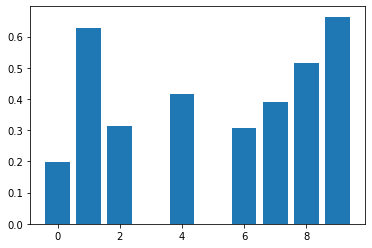

In [41]:
# 我们首先看看整体9个offer的成功率的情况
g_obj = df_clean.groupby(by=["offer_id"])
df_info = g_obj["valid_ind"].agg(['count', 'sum']).reset_index()
df_info["success_rate"] = df_info["sum"]/df_info["count"]

# 明显有两个offer有问题，difficulty是0，也没有成功的参与，感觉是没有开放出来的offer
plt.bar(df_info.index, df_info["success_rate"])
df_info

In [67]:
# 可视化函数，方便反复调用
def visualize_output(offer_id):
    """
    PURPOSE: 对于输入的推送ID，对数据从六个维度分组，输出子图
    INPUT:
        - offer_id：推送ID
    
    OUTPUT:
        - 图形输出，无返回值
    
    """
    if offer_id.strip()!= "":
        print("正在查看offer_id为：{}的数据集。".format(offer_id))
        df_subset = df_clean[df_clean["offer_id"]==offer_id].copy()
    else:
        print("正在查看整个数据集。")
        df_subset = df_clean

    # 我们着重从推送设置和消费者属性上去观察活动的情况
    fig, axes = plt.subplots(3, 2, figsize=(16, 9))
    
    # 推送的设置本身也有可能对最终结果有影响
    sns.barplot(x="difficulty", y="valid_ind", data=df_subset, ax=axes[0][0])
    sns.barplot(x="duration", y="valid_ind", data=df_subset, ax=axes[0][1])

    # 女性对优惠更敏感
    sns.barplot(x="gender", y="valid_ind", data=df_subset, ax=axes[1][0], order=["Male", "Female"])

    # 新会员，参与度稍低
    sns.barplot(x="membership_year", y="valid_ind", data=df_subset, ax=axes[1][1])

    # 年轻群体， 对优惠不太敏感
    sns.barplot(x="age_range", y="valid_ind", data=df_subset, ax=axes[2][0])

    # 高收入群体的反馈更积极
    df_subset["salary_range"] = pd.cut(df_subset["income"], [20000, 40000, 60000, 80000, 100000, df_subset["income"].max()])
    sns.barplot(x="salary_range", y="valid_ind", data=df_subset, ax=axes[2][1])
    plt.show()
    
    return

正在查看整个数据集。


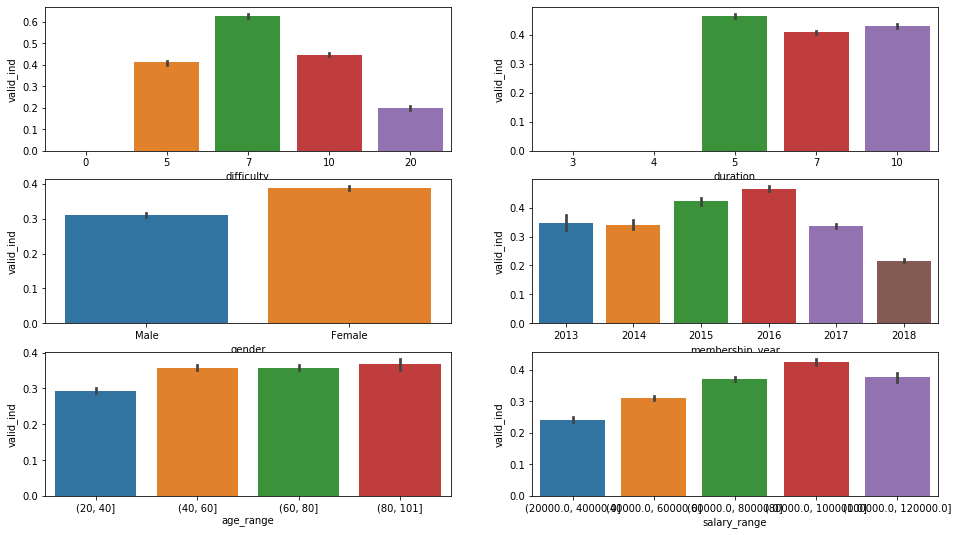

In [68]:
# 查看整个数据集的情况
visualize_output("")

正在查看offer_id为：2298d6c36e964ae4a3e7e9706d1fb8c2的数据集。


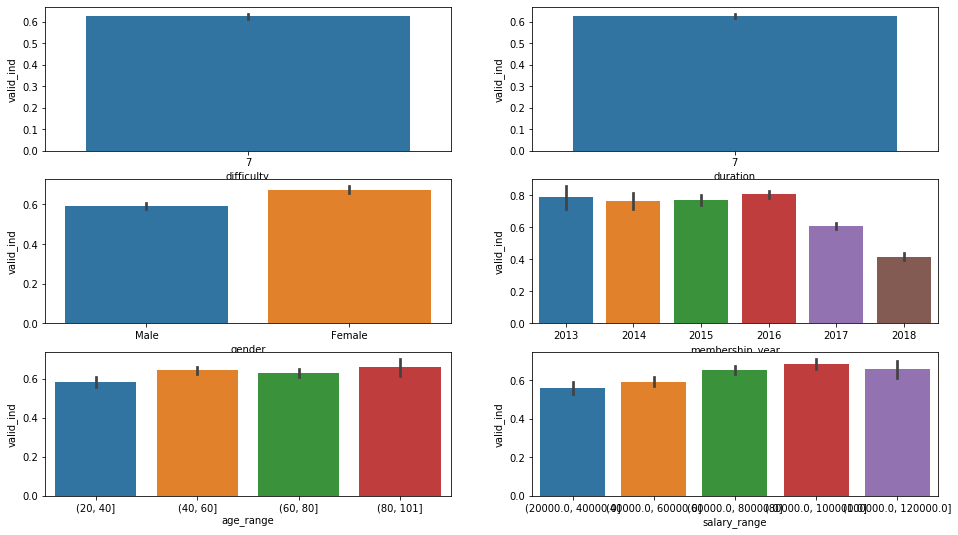

In [69]:
# 查看完成率高的数据集的情况
visualize_output("2298d6c36e964ae4a3e7e9706d1fb8c2")

正在查看offer_id为：0b1e1539f2cc45b7b9fa7c272da2e1d7的数据集。


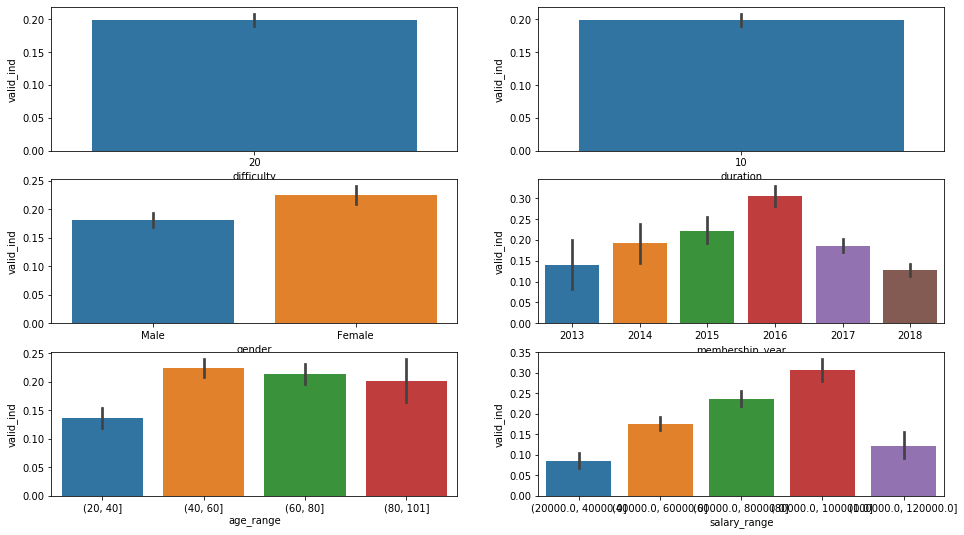

In [70]:
# 查看完成率较低的数据集的情况
visualize_output("0b1e1539f2cc45b7b9fa7c272da2e1d7")

#### 小结

* 活动门槛高，完成率会相应低
* 推送时间短，完成率也相应比较低
* 女性对优惠更敏感
* 年轻群体， 对优惠普遍不太敏感
* 收入对参与度的影响，视offer，有不同
* 新会员，参与度在不同的活动类别中有分化


## 第三步，数据建模分析

目标：建立一个有效的预测模型，同时解释推送成功的各个影响因素的重要程度